<a href="https://colab.research.google.com/github/104H/dyadicdecisionmaking/blob/titration-testing/dataanalysis/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import io
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
sns.set_palette("Set2", desat=0.5)

In [ ]:
"""
Fetch data from git
"""

datasrc = 'https://raw.githubusercontent.com/104H/dyadicdecisionmaking/main/data/DDM_pair55_2021_Sep_14_1905.csv'
samples_df = pd.read_csv(datasrc)

"""
Key params
"""
block_repeat = samples_df['block'].max() - 1
trials_per_block = samples_df['trial'].max() + 1

In [ ]:
#@title Precrocessing {display-mode: "form"}

def remove_unnecessary_columns(samples_df):
    '''
    Remove columns that do not contain important data.
    This targets mainly columns named ".this...".
    '''
    samples_df.drop(
        columns=['.thisRepN', '.thisTrialN', '.thisN', '.thisIndex'],
        inplace=True
    )
    samples_df.drop(
        samples_df.filter(regex='Unnamed').columns, 
        axis=1, 
        inplace=True
    )
    return samples_df
    

def determine_correct_responses(samples_df):
    '''
    Based on the presented condition and the participants
    response, the correct responses are determined and stored
    in a separate column as a boolean value.
    '''
    conditions = [
        (samples_df['condition'] == 'signal') & (samples_df['response'] == 'yes'),
        (samples_df['condition'] == 'signal') & (samples_df['response'] == 'no'),
        (samples_df['condition'] == 'noise')  & (samples_df['response'] == 'yes'),
        (samples_df['condition'] == 'noise')  & (samples_df['response'] == 'no')
    ]
    values = [True, False, False, True]
    samples_df['correct_response'] = np.select(conditions, values).astype('bool')
    
    return samples_df
    
    
def determine_repeated_condition(samples_df):
    '''
    For consequtive trials with the same condition the counter
    increases, when the condition changes the counter is set back
    to zero.
    '''
    pairs = samples_df.pair.unique()
    repeatc = []
    counter = 0

    for pair in pairs:
        for ind in samples_df.query('pair == @pair').index:
            if ind == 0:
                condition = samples_df['condition'][ind]
                repeatc.append(counter)
            else:
                if samples_df['condition'][ind] != condition:
                    condition = samples_df['condition'][ind]
                    counter = 0
                    repeatc.append(counter)
                else:
                    counter += 1
                    repeatc.append(counter)
                
    samples_df['repeated_condition'] = repeatc
    
    return samples_df


def determine_response_behavior(samples_df):
    """
    Segregate and arrange data on a per subject basis since analysis is done per subject.
    Output: every row is a trial data for the 'DO' subject. the dyad is by default in 'OBSERVE' state
    every subject is given a subject id : pair-id_1 or pair-id_2
    """
    temp = samples_df.copy()
    temp['subject_id'] = temp['pair'].apply(str)
    temp.loc[temp['s1_state']==1,'subject_id'] = temp.loc[temp['s1_state']==1,'subject_id'] + '_1'
    temp.loc[temp['s1_state']==0,'subject_id'] = temp.loc[temp['s1_state']==0,'subject_id'] + '_2'

    """
    Encode whether the trial previous to current one was 'DO' by own or by the partner.
    After block_repeats num. of blocks subjects take break, so for every
    t + block_repeat*trials_per_block*d th trial (t0 = 1, d = 0,1,...)
    doesnt make sense to have the previous trial encoding.
    """
    temp['prev_trial'] = temp['subject_id'] == temp['subject_id'].shift()
    temp['prev_trial'] = temp['prev_trial'].map({True:'own',False:'partner'})
    temp.loc[(temp['totalTrials']% (block_repeat*trials_per_block))==1,'prev_trial'] = np.NaN

    """
    Create a column which tells if previous response was correct or error
    After block_repeats num. of blocks subjects take break, so for every
    t + block_repeat*trials_per_block*d th trial (t0 = 1, d = 0,1,...) set to NaN
    """
    temp['prev_correct'] = temp['correct_response'].shift(periods=1)
    temp.loc[(temp['totalTrials']% (block_repeat*trials_per_block))==1,'prev_correct'] = np.NaN

    """
    Encode responses as 'repeat' or 'alternate'.
    'repeat' if response is same as immediate previous response, otherwise 'alternate'.
    After block_repeats num. of blocks subjects take break, so every
    t + block_repeat*trials_per_block*d th trial (t0 = 1, d = 0,1,...)
    for a given pair is neither repeat nor alternate.
    """
    temp['response_code'] = temp['response'] == temp['response'].shift(periods=1)
    temp['response_code'] = temp['response_code'].map({True:'repeat',False:'alternate'})
    temp.loc[(temp['totalTrials']% (block_repeat*trials_per_block))==1,'response_code'] = np.NaN

    """
    Create dump of all experiment data, every line is a DO trial
    """
    experiment_data = temp[['subject_id','pair','block','totalTrials','condition','response','rt','correct_response','repeated_condition','response_code','prev_trial','prev_correct']]
    
    return experiment_data


def remove_noresponse_trials(samples_df):
    '''
    Removes no response trials :P
    '''
    pairs = samples_df.pair.unique()
    noresponse_dict = {}

    for pair in pairs:
        subs = samples_df.query('pair==@pair').subject_id.unique()

        for subject in subs:
            # create subset of dataframe
            subset = samples_df.loc[(samples_df.pair==pair) & (samples_df.subject_id==subject)]

            # get indices of no-response trials
            idx = subset[subset['response'] == 'noresponse'].index

            # add amount of no-response trials to dictionary
            if len(idx)==0:
                noresponse_dict[subject] = 0
            else:
                noresponse_dict[subject] = len(idx)
                samples_df = samples_df.drop(idx).reset_index(drop=True)
    
    return samples_df, noresponse_dict
    
    
def remove_outliers(samples_df):
    '''
    Removes outliers based on the Anne Urai's script.
    '''
    pairs = samples_df.pair.unique()
    samples_df['rt'] = samples_df['rt'].astype(float)
    RTstd = 4
    outlier_dict = {}

    for pair in pairs:
        subs = samples_df.query('pair==@pair').subject_id.unique()

        for subject in subs:
            # create subset of dataframe
            subset = samples_df.loc[(samples_df.pair==pair) & (samples_df.subject_id==subject)]


            values = subset.loc[:,'rt'].values
            mean = np.mean(values)
            std = np.std(values)
            thresh = mean + (std*RTstd)

            # get indices of outliers
            idx = subset.loc[(subset.rt) > thresh].index

            # add amount of outliers to dictionary
            if len(idx)==0:
                outlier_dict[subject] = 0
            else:
                outlier_dict[subject] = len(idx)
                samples_df = samples_df.drop(idx).reset_index(drop=True)


    return samples_df, outlier_dict

if 'totalTrials' not in samples_df.columns:
  samples_df.insert(3, 'totalTrials', np.arange(1, np.shape(samples_df)[0]+1))

experiment_data = determine_response_behavior(
                      determine_repeated_condition(
                          determine_correct_responses(
                              remove_unnecessary_columns(samples_df))))

experiment_data.head()

,subject_id,pair,block,totalTrials,condition,response,rt,correct_response,repeated_condition,response_code,prev_trial,prev_correct
0,55_2,55,1,1,noise,no,1.254475,True,0,NaN,NaN,NaN
1,55_2,55,1,2,signal,yes,0.730195,True,0,alternate,own,True
2,55_2,55,1,3,noise,no,0.792221,True,0,alternate,own,True
3,55_1,55,1,4,noise,no,1.597422,True,1,repeat,partner,True
4,55_2,55,1,5,signal,yes,0.830951,True,0,alternate,partner,True


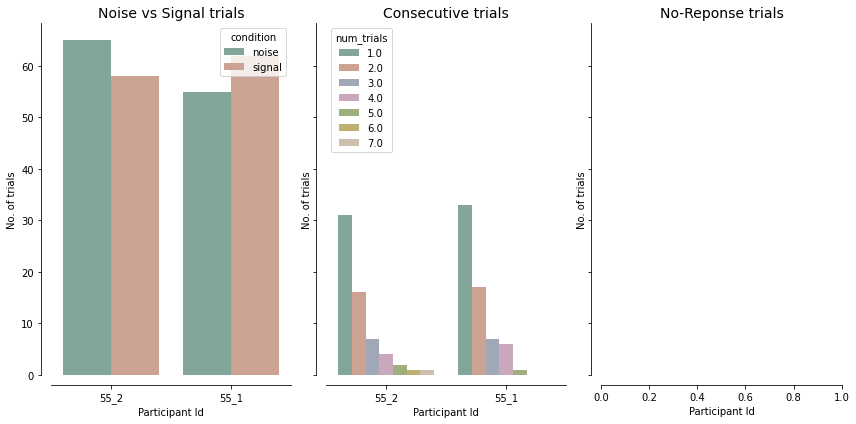

In [ ]:
"""
NOTE: We need to summarize overall trial characteristics data before no-response and ouliers are filtered.
Summarize the trial characteristics:
1. Noise versus signal trials per subject
2. No. of consecutive trial sets of 1/2/3/... trails done by each participant
3. No. of trails with no-response. Where they signal trials or noise ones? Did a subject had too many of those?
"""

#compute the number of sets of consecutive trials of various types done by each subject
tmpdf = experiment_data[['subject_id','prev_trial','totalTrials']]
tmpdf = tmpdf[(tmpdf['prev_trial']=='partner') | (tmpdf['totalTrials']%trials_per_block ==0) | (tmpdf['totalTrials']%trials_per_block ==1)]
tmpdf.sort_values(['totalTrials'])
tmpdf['num_trials'] = tmpdf['totalTrials'].shift(periods=-1) - tmpdf['totalTrials']

#when the next datapoint is another pair then the num_trials is negative. At end of the DF it is NaN. 
#when prev trial is own, add one to num trial of prevous row and drop the records
#when prev trial is partner, make num trial to 1 and keep the record
index1 = tmpdf[((tmpdf['num_trials'] < 0 )|(tmpdf['num_trials'].isna()))&(tmpdf['prev_trial'] == 'own' )].index
index2 = tmpdf[((tmpdf['num_trials'] < 0 )|(tmpdf['num_trials'].isna()))&(tmpdf['prev_trial'] == 'partner' )].index
tmpdf.loc[index1 -1,'num_trials'] += 1
tmpdf.loc[index2,'num_trials'] = 1
tmpdf.drop(index=index1,inplace=True)
tmpdf.drop(['prev_trial','totalTrials'],axis=1,inplace=True)
#print(tmpdf.groupby(['subject_id'])['num_trials'].sum())

#plot the charts now
fig,ax = plt.subplots(1,3, figsize=(12, 6),sharey=True)

sns.countplot(data=experiment_data, x='subject_id', hue='condition', ax=ax[0])
ax[0].set_title('Noise vs Signal trials', fontsize=14)
ax[0].set_xlabel('Participant Id')
ax[0].set_ylabel('No. of trials')

sns.countplot(data=tmpdf, x='subject_id', hue='num_trials', ax=ax[1])
ax[1].set_title('Consecutive trials', fontsize=14)
ax[1].set_xlabel('Participant Id')
ax[1].set_ylabel('No. of trials')

if (len(experiment_data.query("response=='noresponse'"))>0):
  sns.countplot(data=experiment_data.query("response=='noresponse'"), x='subject_id', hue='condition', ax=ax[2])

ax[2].set_title('No-Reponse trials', fontsize=14)
ax[2].set_xlabel('Participant Id')
ax[2].set_ylabel('No. of trials')

sns.despine(offset=10)
fig.tight_layout()
plt.show()

In [ ]:
experiment_data, no_response = remove_noresponse_trials(experiment_data)
print('Amount of no-response trials: ' + str(no_response))

Amount of no-response trials: {'55_2': 0, '55_1': 0}


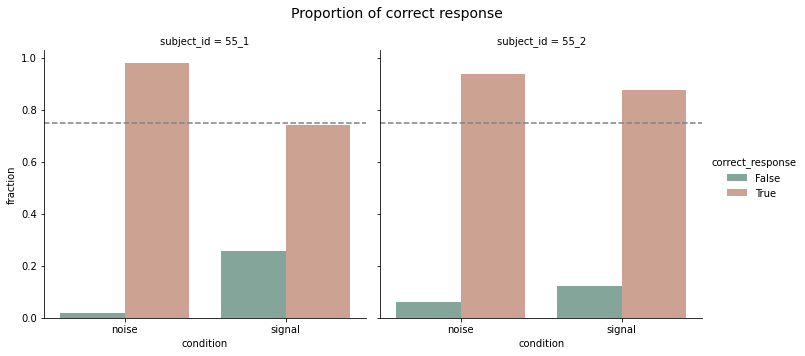

,subject_id,condition,correct_response,fraction
0,55_1,noise,True,0.981818
1,55_1,noise,False,0.018182
2,55_1,signal,True,0.741935
3,55_1,signal,False,0.258065
4,55_2,noise,True,0.938462
5,55_2,noise,False,0.061538
6,55_2,signal,True,0.877193
7,55_2,signal,False,0.122807


In [ ]:
tmpdf = (experiment_data
    .groupby(['subject_id','condition'])['correct_response']
    .value_counts(normalize=True)
    .to_frame()
    .rename(columns={'correct_response': 'proprotion'})
    .reset_index()
)

g = sns.catplot(
    data=tmpdf,
    x='condition',
    y='proportion', 
    hue='correct_response', 
    col='subject_id', 
    kind='bar',
)

g.fig.subplots_adjust(top=0.86)
g.fig.suptitle('Proportion of correct responses', fontsize=14)
g.axes[0][0].axhline(y=0.75, color='grey', linestyle='--')
g.axes[0][1].axhline(y=0.75, color='grey', linestyle='--')
plt.show()

display(tmpdf)
del tmpdf

In [ ]:
experiment_data, outlier = remove_outliers(experiment_data)
print('Amount of outliers: ' + str(outlier))

Amount of outliers: {'55_2': 1, '55_1': 0}


**Exploring the data**

In [ ]:
experiment_data.head(170)

,subject_id,pair,block,totalTrials,condition,response,rt,correct_response,repeated_condition,response_code,prev_trial,prev_correct
0,55_2,55,1,1,noise,no,1.254475,True,0,NaN,NaN,NaN
1,55_2,55,1,2,signal,yes,0.730195,True,0,alternate,own,True
2,55_2,55,1,3,noise,no,0.792221,True,0,alternate,own,True
3,55_1,55,1,4,noise,no,1.597422,True,1,repeat,partner,True
4,55_2,55,1,5,signal,yes,0.830951,True,0,alternate,partner,True
...,...,...,...,...,...,...,...,...,...,...,...,...
165,55_2,55,3,167,signal,yes,1.000907,True,1,repeat,partner,True
166,55_1,55,3,168,noise,no,0.785990,True,0,alternate,partner,True
167,55_2,55,3,169,signal,yes,0.933082,True,0,alternate,partner,True
168,55_2,55,3,170,noise,no,0.978034,True,0,alternate,own,True


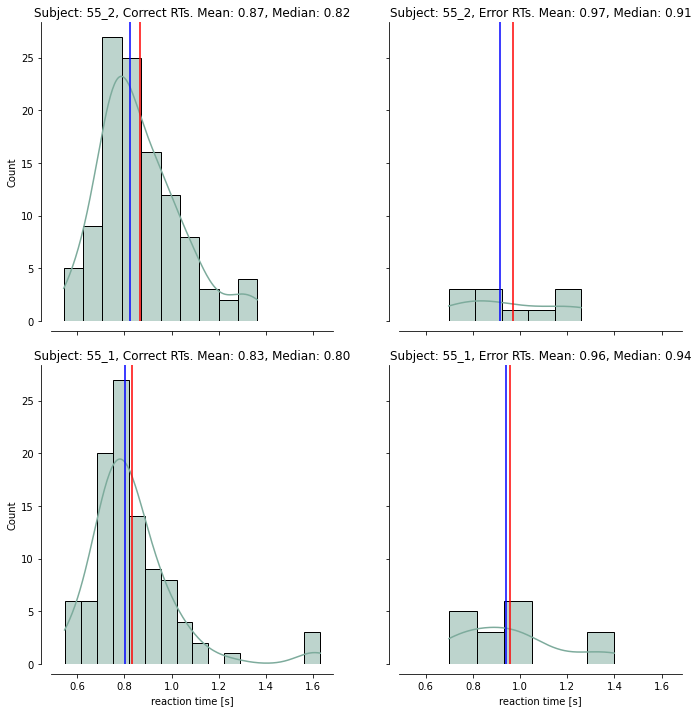

In [ ]:
"""
SB: Copied FB's code and modified
Plot RT for each subject, seperately for error and corerct repsonses.
Things to check:
1. Positive skew (median before mean)
2. Error RTs usually are longer and the histrograms are flatter
"""

subjects = experiment_data['subject_id'].unique()

fig, axes = plt.subplots(len(subjects),2,figsize=(10,10),sharex=True,sharey=True)
axes = axes.flatten()
graph_counter = 0

for sub in subjects:
  tmpdf_corr = (
      experiment_data
      .query('subject_id==@sub and correct_response')
      .reset_index()
  )
  tmpdf_err = (
      experiment_data
      .query('subject_id==@sub and not correct_response')
      .reset_index()
  )
  if tmpdf_corr.shape[0] != 0:
    sns.histplot(data=tmpdf_corr,x="rt", kde=True, ax=axes[graph_counter])
    sns.despine(offset=10)
    mean = tmpdf_corr['rt'].mean()
    median = tmpdf_corr['rt'].median()
    axes[graph_counter].axvline(x=mean,color='red')
    axes[graph_counter].axvline(x=median,color='blue')
    axes[graph_counter].set_title('Subject: {}, Correct RTs. Mean: {:0.2f}, Median: {:0.2f}'.format(sub,mean,median))
    graph_counter += 1
  else:
    axes[graph_counter].set_title('Subject: {}, Correct RTs.'.format(sub))
    axes[graph_counter].text(x=1,y=20,s='No Correct Responses!!')
    graph_counter += 1

  if tmpdf_err.shape[0] != 0:
    sns.histplot(x=tmpdf_err['rt'], kde=True, ax=axes[graph_counter])
    sns.despine(offset=10)
    mean = tmpdf_err['rt'].mean()
    median = tmpdf_err['rt'].median()
    axes[graph_counter].axvline(x=mean,color='red')
    axes[graph_counter].axvline(x=median,color='blue')
    axes[graph_counter].set_title('Subject: {}, Error RTs. Mean: {:0.2f}, Median: {:0.2f}'.format(sub,mean,median))
    graph_counter += 1
  else:
    axes[graph_counter].set_title('Subject: {}, Error RTs.'.format(sub))
    axes[graph_counter].text(x=1,y=20,s='No Error Responses')
    graph_counter += 1

axes[graph_counter-1].set_xlabel('reaction time [s]')
axes[graph_counter-2].set_xlabel('reaction time [s]')
fig.tight_layout(h_pad=1.5)
plt.show()

del tmpdf_corr, tmpdf_err

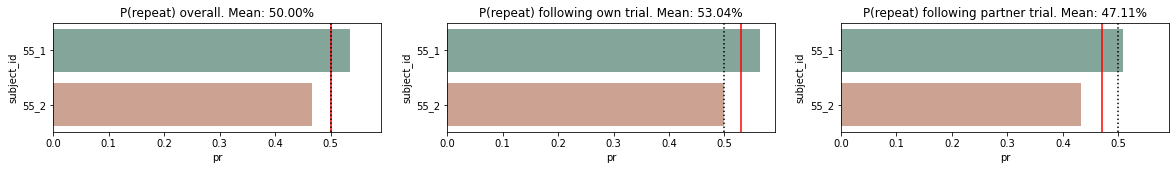

In [ ]:
"""
Calculate probability of repeat for each subject, for overall, for prev trial own and prev trial partner
Calculate the probabilities of repeat under the various conditions and store ina DF, to analyze and plot
Since sample size differ for subjects and conditions, calculations are weighted by sample size.
Plot for all subjects their individual probability of repeat. 

Refer: AU Fig 2.b
"""

#calculate p(repeat) for own and dyadic conditions
tmpdf = experiment_data.groupby(['subject_id','prev_trial'])['response_code'].value_counts().unstack(level=2).reset_index()
tmpdf['n'] = tmpdf.sum(axis=1)
tmpdf['pr'] = tmpdf['repeat']/tmpdf['n']
tmpdf.drop(['alternate'],axis=1,inplace=True)

#calculate p(repeat) for overall
tmpdf1 = experiment_data.groupby(['subject_id'])['response_code'].value_counts().unstack(level=1).reset_index()
tmpdf1['n'] = tmpdf1.sum(axis=1)
tmpdf1['pr'] = tmpdf1['repeat']/tmpdf1['n']
tmpdf1.drop(['alternate'],axis=1,inplace=True)

#plot the 3 charts
fig, axes = plt.subplots(1,3,figsize=(20,2),sharex=True,subplot_kw=dict(xlabel="P(repeat)",ylabel="Subject Id"))
axes = axes.flatten()

sns.barplot(x='pr',y='subject_id',data=tmpdf1,ax=axes[0])
mean = np.average(a=tmpdf1['pr'],weights= tmpdf1['n'])
axes[0].axvline(x=mean,color='red')
axes[0].axvline(x=0.5,color='black',linestyle='dotted')
axes[0].set_title('P(repeat) overall. Mean: {:0.2%}'.format(mean))

for i,typ in enumerate(tmpdf['prev_trial'].unique()):
  sns.barplot(x='pr',y='subject_id',data=tmpdf[tmpdf['prev_trial']==typ],ax=axes[i+1])
  mean = np.average(a=tmpdf[tmpdf['prev_trial']==typ]['pr'],weights=tmpdf[tmpdf['prev_trial']==typ]['n'])
  axes[i+1].axvline(x=mean,color='red')
  axes[i+1].axvline(x=0.5,color='black',linestyle='dotted')
  axes[i+1].set_title('P(repeat) following {} trial. Mean: {:0.2%}'.format(typ, mean))

plt.show()

del tmpdf, tmpdf1


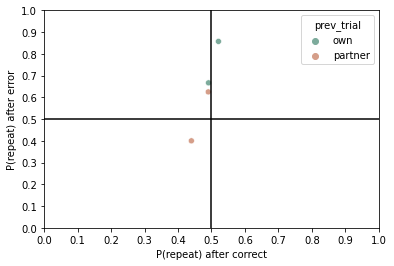

In [ ]:
"""
Plot each individual’s tendency to repeat their choices after correct vs. error trials. 
Reponses following own trial and partner trial are color coded
Refer: AU Fig 2.c
"""
#calculate p(repeat) after correct and error trials
tmpdf = experiment_data.groupby(['subject_id','prev_trial','prev_correct'])['response_code'].value_counts(normalize=True)
tmpdf = tmpdf.unstack(level=2).fillna(0).reset_index()
tmpdf = tmpdf[tmpdf['response_code']=='repeat']

#scatter plot
fig, ax = plt.subplots(1)
sns.scatterplot(x=tmpdf[True],y=tmpdf[False],hue=tmpdf['prev_trial'],ax=ax)
ax.set_xticks(np.linspace(0,1,11))
ax.set_yticks(np.linspace(0,1,11))
ax.axvline(x=0.5,color='black')
ax.axhline(y=0.5,color='black')
ax.set_xlabel("P(repeat) after correct")
ax.set_ylabel("P(repeat) after error")
plt.show()

del tmpdf

In [ ]:
experiment_data['rt'].quantile(q=[0.2,0.4,0.6,0.8])

0.2    0.726318
0.4    0.790572
0.6    0.857638
0.8    0.982037
Name: rt, dtype: float64